## Appendix E: Parameter-efficient Finetuning with LoRA

In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.8
numpy version: 2.2.6
tiktoken version: 0.12.0
torch version: 2.9.1
tensorflow version: 2.20.0
pandas version: 2.3.3


### E.2 Preparing the dataset

In [3]:
# import urllib
import requests
from pathlib import Path
import pandas as pd
from previous_chapters import (
    download_and_unzip_spam_data,
    create_balanced_dataset,
    random_split
)
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch06 import (
#     download_and_unzip_spam_data,
#     create_balanced_dataset,
#     random_split
# )



url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

# The book originally used
# except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
# in the code above.
# However, some VPN users reported issues with `urllib`, so the code was updated
# to use `requests` instead

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [4]:
import torch
import tiktoken
from previous_chapters import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [5]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [6]:
print("Train Loader:")

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train Loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [7]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### E.3 Initializing the model

In [8]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# Alternatively:
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import load_weights_into_gpt



CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 51.3kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.42MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 76.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:15<00:00, 6.60MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.12MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 633kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 641kiB/s] 


In [9]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [10]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

model.to(device);  # no assignment model = model.to(device) necessary for nn.Module classes

Device: mps


In [12]:
from previous_chapters import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### E.4 Parameter-efficient finetuning with LoRA

In [13]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        self.rank = rank
    def forward(self, x):
        x = (self.alpha / self.rank) * (x @ self.A @ self.B)
        return x;    

In [14]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
    def forward(self, x):
        return self.linear(x) + self.lora(x)


In [15]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [18]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [19]:
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [20]:
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [21]:
import time
from previous_chapters import train_classifier_simple

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.346, Val loss 0.325
Ep 1 (Step 000100): Train loss 0.063, Val loss 0.144
Training accuracy: 100.00% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.054, Val loss 0.045
Ep 2 (Step 000200): Train loss 0.058, Val loss 0.122
Ep 2 (Step 000250): Train loss 0.041, Val loss 0.199
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.020, Val loss 0.153
Ep 3 (Step 000350): Train loss 0.017, Val loss 0.189
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.017, Val loss 0.094
Ep 4 (Step 000450): Train loss 0.001, Val loss 0.135
Ep 4 (Step 000500): Train loss 0.005, Val loss 0.278
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.015, Val loss 0.185
Ep 5 (Step 000600): Train loss 0.003, Val loss 0.112
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 4.11

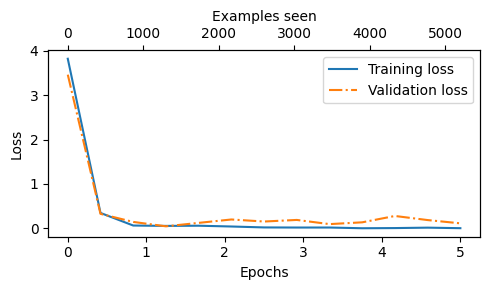

In [22]:
from previous_chapters import plot_values
# Alternatively:
# from llms_from_scratch.ch06 import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [23]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.62%
Validation accuracy: 97.32%
Test accuracy: 97.33%
